In [1]:
import glob
import warnings

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import read as read_xyz
from dscribe.descriptors import SOAP
from astartes import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## Data Loading

In [2]:
structures = [read_xyz(x) for x in glob.glob("../data/raw/*.xyz")]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

len(structures)

999

In [ ]:
pca_components = 5
soap = SOAP(
    r_cut=5,
    n_max=1,
    l_max=7,
    species=["Au"],
    periodic=False,
    average="outer",
    sparse=False
)

soap

In [4]:
X = soap.create(structures, n_jobs=2) #.reshape(999, -1)
y = energy_levels.copy()

X.shape, y.shape

((999, 8), (999,))

In [5]:
# random, kennard_stone
X_train, X_test, y_train, y_test = train_test_split(X, y, sampler="random", train_size=0.65, random_state=22)

# kmeans
# X_train, X_test, y_train, y_test, _, _ = train_test_split(X, y, sampler="kmeans", train_size=0.65, random_state=21)

X_train.shape, X_test.shape

((649, 8), (350, 8))

## Cross Validation

In [ ]:
def get_model(model_name):
    if model_name == "extra-trees":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", ExtraTreesRegressor())
        ])
    elif model_name == "xgboost":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", XGBRegressor())
        ])
    elif model_name == "lightgbm":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", LGBMRegressor(verbose=-1))
        ])
    elif model_name == "stacking":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", StackingRegressor(
                final_estimator=LinearRegression(),
                estimators=[
                    ("etr", ExtraTreesRegressor()), 
                    ("xgb", XGBRegressor()), 
                    ("lgb", LGBMRegressor(verbose=-1))
                ]
            ))
        ])
    
    raise ValueError("Unknown model name!")

In [20]:
results = []

with warnings.catch_warnings(action="ignore"):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_index, val_index) in enumerate(cv.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        print(f"Fold {i+1}...", end="")

        for model_name in ["extra-trees", "xgboost", "lightgbm", "stacking"]:
            print(f"{model_name}..", end="")

            model = get_model(model_name)
            model.fit(X_train, y_train)

            y_preds = model.predict(X_val)
            results.append({
                "fold": i,
                "model_name": model_name,
                "r2": r2_score(y_val, y_preds),
                "mae": mean_absolute_error(y_val, y_preds),
                "rmse": root_mean_squared_error(y_val, y_preds),
            })

        print("")

Fold 1...extra-trees..xgboost..lightgbm..stacking..
Fold 2...extra-trees..xgboost..lightgbm..stacking..
Fold 3...extra-trees..xgboost..lightgbm..stacking..
Fold 4...extra-trees..xgboost..lightgbm..stacking..
Fold 5...extra-trees..xgboost..lightgbm..stacking..


In [21]:
df_results = pd.DataFrame(results)
df_results.pivot_table(index=["model_name"], values=["r2", "mae", "rmse"], aggfunc=["mean", "std"]) \
    .sort_values([("mean", "r2")], ascending=False)

mean                           std                    
                  mae        r2      rmse       mae        r2      rmse
model_name                                                             
stacking     0.438438  0.935199  0.726789  0.023320  0.011480  0.073881
extra-trees  0.431607  0.930553  0.752115  0.021290  0.010237  0.052987
xgboost      0.463998  0.926079  0.776266  0.037869  0.015146  0.099539
lightgbm     0.484437  0.924366  0.783946  0.026560  0.021505  0.131119

## Final Model

In [22]:
with warnings.catch_warnings(action="ignore"):
    model = get_model("extra-trees")
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    print("MAE", mean_absolute_error(y_test, y_preds))
    print("RMSE", root_mean_squared_error(y_test, y_preds))
    print("R2", r2_score(y_test, y_preds))

MAE 0.08679685270329628
RMSE 0.2915866604909752
R2 0.9898066244097679


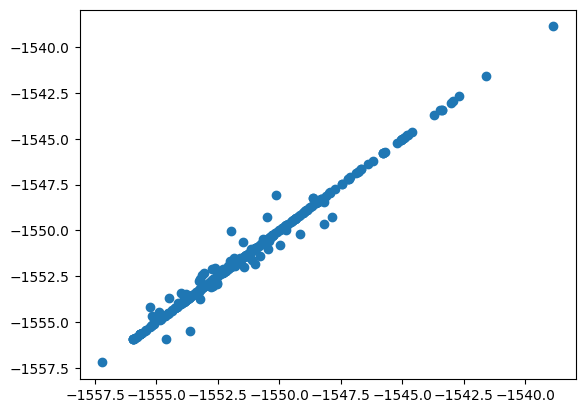

In [23]:
fig, ax = plt.subplots()

ax.scatter(y_preds, y_test)

plt.show()

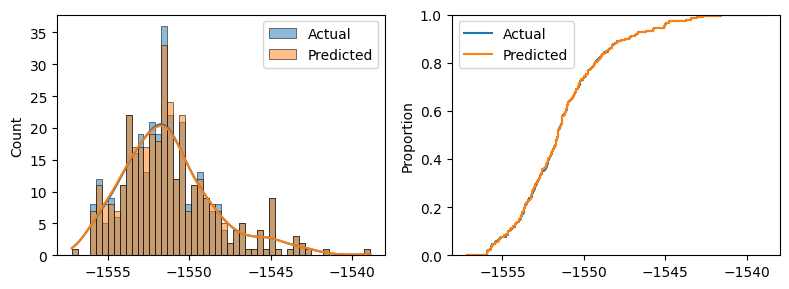

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(y_test, bins=50, kde=True, ax=ax1, label="Actual")
sns.histplot(y_preds, bins=50, kde=True, ax=ax1, label="Predicted")
ax1.legend()

sns.ecdfplot(y_test, ax=ax2, label="Actual")
sns.ecdfplot(y_preds, ax=ax2, label="Predicted")
ax2.legend()

fig.tight_layout()
plt.show()

In [25]:
sp.stats.ttest_ind(y_test, y_preds)

TtestResult(statistic=np.float64(0.03891451768996409), pvalue=np.float64(0.9689696691127768), df=np.float64(698.0))

In [26]:
sp.stats.ks_2samp(y_test, y_preds)

/home/fahmi/research/ieee-cyberc-2025/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


KstestResult(statistic=np.float64(0.011428571428571429), pvalue=np.float64(1.0), statistic_location=np.float64(-1553.0693764374998), statistic_sign=np.int8(-1))

To report an independent samples Kolmogorov-Smirnov (K-S) test in APA style, state the test's purpose, then provide the test statistic (D), followed by the sample sizes for each group in parentheses, and the exact p-value. For example: "There was a significant difference in scores between the two groups, D(n = 25, n = 28) = .25, p = .03". If the result is not significant, state p > .05. 